# 366 - Stone Game III

## Problem Statement

Two players, Anton and Bernhard, are playing the following game.<br>
There is one pile of $n$ stones.<br>
The first player may remove any positive number of stones, but not the whole pile.<br>
Thereafter, each player may remove at most twice the number of stones his opponent took on the previous move.<br>
The player who removes the last stone wins.

E.g. $n=5$.<br>
If the first player takes anything more than one stone the next player will be able to take all remaining stones.<br>
If the first player takes one stone, leaving four, his opponent will take also one stone, leaving three stones.<br>
The first player cannot take all three because he may take at most $2 \times 1=2$ stones. So let's say he takes also one stone, leaving $2$. The second player can take the two remaining stones and wins.<br>
So $5$ is a losing position for the first player.<br>
For some winning positions there is more than one possible move for the first player.<br>
E.g. when $n=17$ the first player can remove one or four stones.

Let $M(n)$ be the maximum number of stones the first player can take from a winning position <i>at his first turn</i> and $M(n)=0$ for any other position.

$\sum M(n)$ for $n \le 100$ is $728$.

Find $\sum M(n)$ for $n \le 10^{18}$. Give your answer modulo $10^8$.

## Solution

Given the large value of $n$, it is not computationally feasible to get to the solution by brute force. However, we can simulate the game for small $n$ values and try to identify a pattern.
Let's create a function to solve for $M(n)$ using dynamic programming and memoization. 



In [42]:
import matplotlib.pyplot as plt

In [43]:
memo = {}

def get_upper_bound(n, moves):
    """ Get upper bound of the for loop """
    prev = n
    if moves:
        prev = moves[-1]
    if n % 2 == 0:
        upper_bound = min(n // 2 - 1, prev * 2)
    else:
        upper_bound = min(n // 2, prev * 2)
    return upper_bound

def solve(n, moves, player):
    """
    Function representing M(n).

    Parameters
    ----------
    n : int
        number of stones remaining
    moves : list
        list of moves played so far
    player : int
        1 when Anton plays, 2 when Bernhard plays

    Returns
    -------
        Maximum number of stones Anton can take on first move to win the game. 0 if Anton cannot win.
    """
    # Handle case where the game is starting
    if moves:
        last_move = moves[-1]
    else:
        last_move = -1
    # Check if solution already exists for the current setup
    if (n, last_move, player) in memo:
        if memo[(n, last_move, player)] != 0:
            return moves[0]
        return 0
    # Anton's turn
    if player == 1:
        # Check if player can take all the remaining stones
        if moves and n <= 2 * moves[-1]:
            return moves[0]
        # If Anton can win with a move, it must be the maximum as the loop starts with highest allowed move
        for x in range(get_upper_bound(n, moves), 0, -1):
            moves.append(x)
            res = solve(n - x, moves, 2)
            if res:
                memo[(n, last_move, player)] = 1
                ans = moves[0]
                moves.pop()
                return ans
            moves.pop()
        memo[(n, last_move, player)] = 0
        return 0
    # Bernhard's turn
    else:
        # Check if player can take all the remaining stones
        if moves and n <= 2 * moves[-1]:
            return 0
        # If Bernhard can win from any of its allowed moves, Anton cannot win with his last move
        for x in range(get_upper_bound(n, moves), 0, -1):
            moves.append(x)
            res = solve(n - x, moves, 1)
            moves.pop()
            if res == 0:
                memo[(n, last_move, player)] = 0
                return 0
        memo[(n, last_move, player)] = 1
        return moves[0]

Let's simulate for $n \leq 2000$ and make sure we have the correct result for $M(100)$.

In [44]:
memo = {}
winnnig_moves = []
for i in range(1, 1001):
    res = solve(i, [], 1)
    winnnig_moves.append(res)

sum(winnnig_moves[:100])

728

Our implementation returns the correct result for $M(100)$. Now let's plot the results.

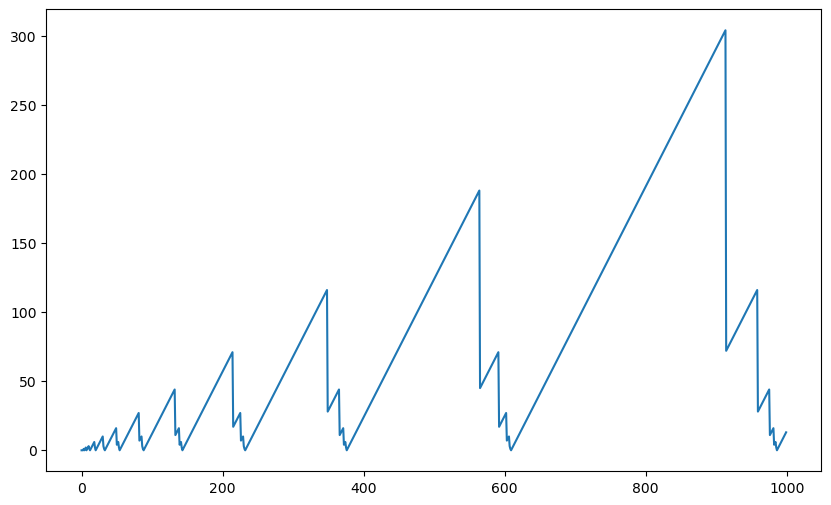

In [45]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(winnnig_moves);

The plot seems to reveal a cyclical pattern that we can exploit. Looking at the data, we observe that each cycle starts and ends with a value of zero. Interestingly, all the zero values (i.e., losing positions for Anton) happen when $n$ is part of the Fibonacci sequence.

In [46]:
[i + 1 for i in range(len(winnnig_moves)) if winnnig_moves[i] == 0]

[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987]

Let's analyse the peak values in the cycle.

In [47]:
def find_cycle_peaks(values):
    peaks = [0]
    max_so_far = float('-inf')
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1] and values[i] > max_so_far:
            peaks.append(values[i])
            max_so_far = values[i]
    return peaks

peaks = find_cycle_peaks(winnnig_moves)
peaks

[0, 1, 2, 3, 6, 10, 16, 27, 44, 71, 116, 188, 304]

Each cycle follows the pattern described below

- Start a zero.
- Increases linearly 1 by 1 until reaching a peak $p(i)$ where $i$ indicates that $p(i)$ is the $i$-th peak. It is defined as
\begin{equation}
        p(i) = \begin{cases} p(i - 1) + p(i - 2) & \text{if} \quad i \mod 3 = 0 \\
            p(i - 1) + p(i - 2) + 1 & \text{if} \quad i \mod 3 \neq 0.
        \end{cases}
\end{equation}
- Drops to $p(i - 3) + 1$ and then increases linearly one by one until reaching $p(i - 2)$.
- Drops to $p(i - 5) + 1$ and then increases linearly one by one until reaching $p(i - 4)$.
- Drops to $p(i - 7) + 1$ and then increases linearly one by one until reaching $p(i - 6)$.
- Continues until $p(0)$ is reached.

We can easily generate the peak values and sum all the values in between. As values increases linearly one by one, we can use the property that the sum of all the values from 0 to the peak value is equal to $\frac{x(x + 1)}{2} + 1$.

In [53]:
def get_sum_winning_moves(limit):
    res = 1
    i = 0
    peaks = [0, 1]
    count = 4
    while True:
        if i % 3 == 1:
            peaks.append(peaks[-1] + peaks[-2])
        else:
            peaks.append(peaks[-1] + peaks[-2] + 1)
        i += 1
        if count + peaks[-1] < limit:
            count += peaks[-1] + 1
            res += peaks[-1] * (peaks[-1] + 1) // 2
        else:
            delta = limit - (count + 1)
            res += delta * (delta + 1) // 2
            count += delta + 1
            return res % 10**8
        for k in range(len(peaks) - 3, 0, -2):
            if count + peaks[k] - peaks[k-1] < limit:
                count += peaks[k] - peaks[k-1]
                res += ((peaks[k] * (peaks[k] + 1)) // 2) - ((peaks[k - 1] * (peaks[k - 1] + 1)) // 2)
            else:
                delta = limit - count
                upper_val = delta + peaks[k-1]
                res += ((upper_val * (upper_val + 1)) // 2) - (peaks[k-1] * (peaks[k-1] + 1)) // 2
                count += delta
                return res % 10**8

In [ ]:
def get_sum_winning_moves(limit):
    res = 1
    i = 0
    peaks = [0, 1]
    count = 4
    while True:
        if i % 3 == 1:
            peaks.append(peaks[-1] + peaks[-2])
        else:
            peaks.append(peaks[-1] + peaks[-2] + 1)
        i += 1
        if count + peaks[-1] < limit:
            count += peaks[-1] + 1
            res += peaks[-1] * (peaks[-1] + 1) // 2
        else:
            delta = limit - (count + 1)
            res += delta * (delta + 1) // 2
            count += delta + 1
            return res % 10**8
        for k in range(len(peaks) - 3, 0, -2):
            if count + peaks[k] - peaks[k-1] < limit:
                count += peaks[k] - peaks[k-1]
                res += ((peaks[k] * (peaks[k] + 1)) // 2) - ((peaks[k - 1] * (peaks[k - 1] + 1)) // 2)
            else:
                delta = limit - count
                upper_val = delta + peaks[k-1]
                res += ((upper_val * (upper_val + 1)) // 2) - (peaks[k-1] * (peaks[k-1] + 1)) // 2
                count += delta
                return res % 10**8

In [55]:
limit = 10**18
get_sum_winning_moves(limit)

88351299